In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import os
import ketu
import numpy as np
import matplotlib.pyplot as pl
from transit import SimpleSystem

In [29]:
campaign = 1
# epicid = "201367065"
# epicid = "201912552"
epicid = "201763507"
basepath = "/Users/dfm/data/k2"
light_curve_file = os.path.join(basepath, "lightcurves/c{0}".format(campaign),
                                "{0}00000/{1}000/ktwo{2}-c{3:02d}_lpd-lc.fits"
                                .format(epicid[:4], epicid[4:6], epicid, campaign))

query = dict(
    invert=False,
    light_curve_file=light_curve_file,
    basis_file=os.path.join(basepath, "elcs/c{0}-norm.h5".format(campaign)),
    catalog_file=os.path.join(basepath, "catalogs/epic.h5"),
    nbasis=500,
    initial_time=1975.0,
    skip=50,
#     initial_time=2015.,
#     skip=0,
    durations=[0.05, 0.1, 0.2],
    min_period=3.,
    max_period=50.,
    npeaks=4,
    # use_gp=False,
)

In [30]:
pipe = ketu.k2.Data(cache=False)
pipe = ketu.k2.Likelihood(pipe, cache=False)
pipe = ketu.OneDSearch(pipe, cache=True, clobber=True)
# pipe = ketu.TwoDSearch(pipe, cache=False)
pipe = ketu.IterativeTwoDSearch(pipe, cache=True, clobber=True)
pipe = ketu.Vetter(pipe, cache=False)

In [31]:
r = pipe.query(**query)

Querying Data
Finished querying Data in 0.55s
Querying Likelihood
tau = 2.65524291992
tau = 2.67562866211
tau = 2.67562866211
tau = 1.86932373047
tau = 1.82879638672
tau = 1.82879638672
Finished querying Likelihood in 4.51s
Querying OneDSearch
Finished querying OneDSearch in 40.71s
Querying IterativeTwoDSearch
Finished querying IterativeTwoDSearch in 145.82s
Querying Vetter
Finished querying Vetter in 6.93s


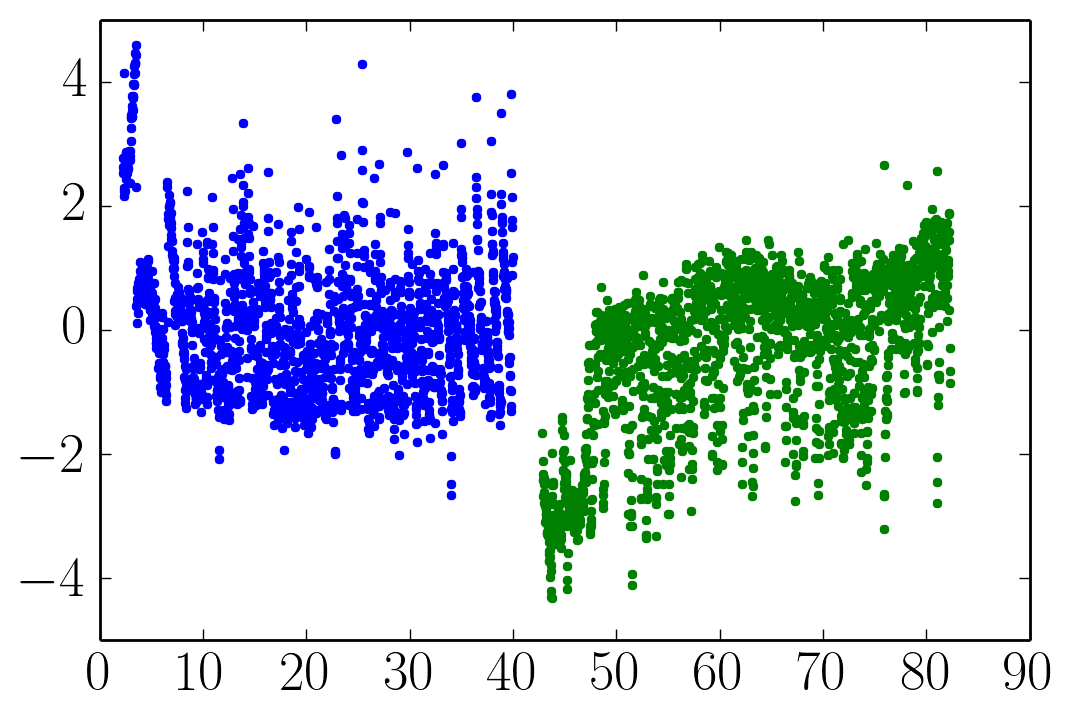

In [32]:
lcs = r.model_light_curves
[pl.plot(lc.time, lc.flux, ".") for lc in lcs];

In [33]:
r.peaks

[{'depth': 1.4424564141802729,
  'depth_ivar': 142.62326105305544,
  'duration': 0.05,
  'lnZ_box': -1024.9246860881558,
  'lnZ_none': -1230.9530950564297,
  'lnZ_outlier': -1182.2596215160904,
  'lnZ_transit': -1009.3841683289896,
  'lnlike_box': -1023.3323888902033,
  'lnlike_none': -1230.9530950564297,
  'lnlike_outlier': -1181.4068568486875,
  'lnlike_transit': -991.08454728196978,
  'period': 11.230933224131762,
  'phic_same': -1715.9054766592506,
  'phic_same_second': -1769.8377245768579,
  'phic_variable': -9187.656712016149,
  's2n': 17.22653299682613,
  't0': 6.5870849609374957,
  'transit_b': 0.47761638784905458,
  'transit_duration': 0.059605202344605493,
  'transit_period': 11.231987427168777,
  'transit_q1': 0.49934333943153114,
  'transit_q2': 0.49988811288568125,
  'transit_ror': 0.041529312716318184,
  'transit_t0': 6.583289850538919},
 {'depth': 0.89499677439458714,
  'depth_ivar': 306.56820575927736,
  'duration': 0.1,
  'lnZ_box': -843.55308525545695,
  'lnZ_none': -

(3.583289850538919, 9.5832898505389181)

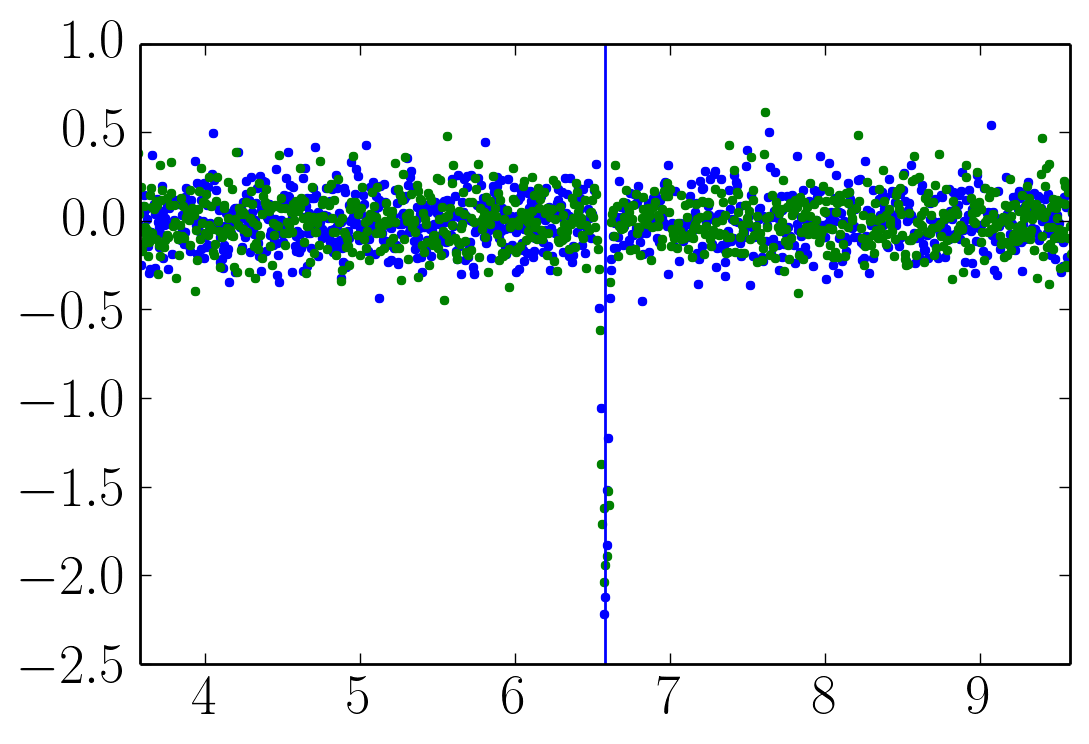

In [37]:
p = r.peaks[0]

s = SimpleSystem(period=p["transit_period"],
                 t0=p["transit_t0"],
                 ror=p["transit_ror"],
                 impact=p["transit_b"],
                 duration=p["transit_duration"],
                 q1=p["transit_q1"],
                 q2=p["transit_q2"])

[pl.plot(lc.time % (p["transit_period"]), lc.flux - lc.predict(lc.flux - 1e3*(s.light_curve(lc.time)-1.0)), ".") for lc in lcs]
pl.gca().axvline(p["transit_t0"]);
pl.xlim(p["transit_t0"]-3, p["transit_t0"]+3)